In [2]:
%load_ext watermark
%watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
2017-04-22T07:57:01

CPython 2.7.6
IPython 5.2.2

compiler   : GCC 4.8.4
system     : Linux
release    : 4.4.43-boot2docker
machine    : x86_64
processor  : x86_64
CPU cores  : 1
interpreter: 64bit


In [3]:
import numpy as np
import tensorflow as tf
print(tf.__version__)

1.0.0


In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
import jieba
from jieba import posseg as pseg
from collections import Counter, defaultdict
import random
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine
import time
import math

In [5]:
RAW_FILE = 'happiness.txt'

In [6]:

word_cnt = Counter()
segs = []
ngram = 2
DELIMITER = u'.'
with open(RAW_FILE) as f:
    lines = f.readlines()
    for line in lines:
        line = line.strip().decode('utf-8')
        words = pseg.cut(line)
        for word, flag in words:            
            if flag == 'x':
                segs.append(DELIMITER)
            else:
                segs.append(word)                
                word_cnt[word] += 1 
        

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.314 seconds.
Prefix dict has been built succesfully.


In [7]:
print(len(segs))
print(len(word_cnt))

for (w,v) in word_cnt.most_common()[:10]: 
    print w,v  


259688
15899
的 22805
是 4335
在 3525
他 2562
了 2273
人 2245
他们 1811
和 1729
这 1611
有 1534


In [8]:
print(len(word_cnt))

vocab_dict = []
vocab_dict.append('Unknown')

for (w,v) in word_cnt.items():
    if v> 5:
        vocab_dict.append(w)
        
vocab_size = len(vocab_dict)
print(vocab_size)


15899
3520


In [9]:
for w in vocab_dict[:10]:
    print w

Unknown
居于
爱慕
出来
第二
还要
肉体上
少数几个
谈
看作


In [10]:
def get_word_index(word, dicts):
    index = -1
    if word in dicts:
        index = dicts.index(word)
    elif not word == DELIMITER:
        index = 0 #未命中词
    else:
        index = -1 #delimiter, context 输入时忽略，delimiter前后的词被切断，不作为context输入    
    
    return index   

In [11]:
def build_seg_index(raw_segs, dicts):
    seg_index = []
    for seg in raw_segs:
        seg_index.append(get_word_index(seg, dicts))
    return seg_index

In [12]:
segs_index = build_seg_index(segs, vocab_dict)

print(segs_index[:10])

[267, 2237, -1, 1385, 2273, 690, 2988, 3304, 3445, 3467]


In [13]:
def get_input_data(seg_index):
    contexts = []
    labels = []
    for i in range(len(seg_index)-2):
        if (seg_index[i] < 0):
            continue
        if (seg_index[i+1] < 0):            
            continue
        contexts.append([seg_index[i], seg_index[i+1]])
        labels.append(max(0, seg_index[i+2]))
    return (contexts, labels)

In [14]:
#input_data = get_input_data(segs_index)
(input_context, input_labels) = get_input_data(segs_index)

print(len(input_context))
print(len(input_labels))

print(input_context[:10])
print(input_labels[:10])

192236
192236
[[267, 2237], [1385, 2273], [2273, 690], [690, 2988], [2988, 3304], [3304, 3445], [3445, 3467], [3467, 1453], [1453, 2239], [1805, 3165]]
[0, 690, 2988, 3304, 3445, 3467, 1453, 2239, 0, 0]


In [15]:
train_data_size = len(input_context)
batch_size = 100

batch_per_round = (train_data_size / batch_size) + 1
print batch_per_round

1923


# Softmax

In [16]:
tf.reset_default_graph()

In [35]:
# 决定了 embedding 的维度 （隐层节点数）
word_embedding_dim = 50
# 决定了词表数量, 预留一个未登录词

UNK_IDX = 0

# 这里需要把 Word embedding 放到 Variable 里面。因为 Word embedding 是要随机初始化，跟着数据不断变化的。
# 它相当于普通神经网络中的权重。

# 在梯度下降时， tensorflow 的 Optimizer 会自动找到 Graph 中的 Variable，计算梯度并进行更新。
word_embedding = tf.Variable(tf.random_uniform([vocab_size, word_embedding_dim]))

# placeholder 和 variable 基本都可以当做 Tensor 来用
# 注意这里的输入是 int32 类型，表示一个词 ID。这里我们需要对数据进行预处理，以把高频词映射到 [1, 80000] 之间，不在词表里面的词设置成 UNK, ID 为 0
# 这里我们假设输入是两个词

# 这里 Shape 的第一维我们指定为 None，是表示第一维可以根据数据进行变化，因此同样一个程序可以适应梯度下降时不同的 batch_size
input_data = tf.placeholder(tf.int32, shape=[None, 2], name='input_data')

input_embeds = tf.nn.embedding_lookup(word_embedding, input_data)

# reduce 开头的函数一般有一个 axis 参数，决定按行、按列或者按整个矩阵进行 reduce
context_embeds = tf.reduce_sum(input_embeds, axis=1)

# 激活之前的输出
raw_output = tf.layers.dense(context_embeds, vocab_size)
# 加 softmax 之后的输出
output = tf.nn.softmax(raw_output)

# 样本的 labels 也需要用 placeholder 放置
labels = tf.placeholder(tf.int32, shape=[None], name='labels')

# 因为我们每个样本的 label 只有一个，使用稠密的 softmax 算 cost 及求导太浪费了。这里使用 sparse 版本即可。
# 如果你的 label 是完整的 N 个词上的概率分布，这时候可以使用 tf.nn.softmax_cross_entropy_with_logits
cost = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=raw_output, labels=labels)

train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cost)

In [36]:
epoches = 10
display_steps = 1

cost0 = []
cost1 = []


with tf.Session() as sess:
    train_start = time.time()
    sess.run(tf.global_variables_initializer())
    
    for i in range(epoches):        
        data_ptr = 0        
        for j in range(batch_per_round):
            if j == batch_per_round-1:
                data_ptr = train_data_size - batch_size
            feed_dict = {input_data: input_context[data_ptr:data_ptr+batch_size],
                             labels: input_labels[data_ptr:data_ptr+batch_size]}
            data_ptr += batch_size
            
            sess.run(train_step, feed_dict=feed_dict)
            
        if (i % display_steps) == 0:
            print("epoch %d" %i)
            cost_train = cost.eval(feed_dict=feed_dict)
            print("Cost: %f, %f" % (cost_train[0], cost_train[1]))
            cost0.append(cost_train[0])
            cost1.append(cost_train[1])
            print("Probability: %f" % output.eval(feed_dict=feed_dict)[0, 3])
            print("------")            
        
    word_embedding_final = sess.run(word_embedding)
    output_final = output.eval(feed_dict=feed_dict)
    
    train_end = time.time()
    duration = train_end - train_start
    print("Softmax Training duration=%.2f" % duration)
    

epoch 0
Cost: 7.197510, 3.314429
Probability: 0.000083
------
epoch 1
Cost: 6.664127, 2.815690
Probability: 0.000041
------
epoch 2
Cost: 6.451363, 2.563116
Probability: 0.000023
------
epoch 3
Cost: 6.255911, 2.397075
Probability: 0.000014
------
epoch 4
Cost: 6.064359, 2.239144
Probability: 0.000010
------
epoch 5
Cost: 5.884868, 2.072106
Probability: 0.000008
------
epoch 6
Cost: 5.726837, 1.917528
Probability: 0.000007
------
epoch 7
Cost: 5.583937, 1.778972
Probability: 0.000007
------
epoch 8
Cost: 5.449971, 1.657970
Probability: 0.000006
------
epoch 9
Cost: 5.319761, 1.556361
Probability: 0.000005
------
Softmax Training duration=624.91


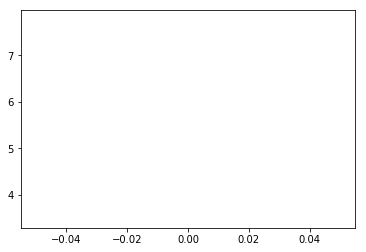

In [19]:
plt.plot(cost0)
plt.plot(cost1)

In [20]:
def get_random_words(cnt, dicts):
    if cnt < 1:
        cnt = 1
    words = []
    index = []
    for i in range(cnt):
        n = random.randrange(0,len(vocab_dict),1)
        words.append(dicts[n])
        index.append(n)
    return words, index
        

In [21]:
def get_cosine_distance_matrix(word_em):
    dist_out = 1-pairwise_distances(word_em, metric="cosine")
    for i in range(len(dist_out)):
        dist_out[i][i] = 0 #将矩阵对角线设为0，不计算每个词与自己的距离
    return dist_out

In [22]:
word_dist = get_cosine_distance_matrix(word_embedding_final)

In [23]:
def get_nearest_word(index, dist_em, top_count):
    z = dist_em[index].argsort()[-top_count:]
    return z

In [37]:
random_index = [31,53,83]
word_dist = get_cosine_distance_matrix(word_embedding_final)

for i in range(len(random_index)):
    index = get_nearest_word(random_index[i], word_dist, 10)
    print index
    print("Nearest words to %s,%d are:" % (vocab_dict[random_index[i]], random_index[i]))
    for j in index:
        print vocab_dict[10-j+1]

[1673 2269 2379 3150 2916 3213 2773 1113 2451 1648]
Nearest words to 罪人,31 are:
遇到
必要
各国
忌妒
怎样
假定
这样的话
文艺复兴
并使
从而
[1925 2439 1433  471 2926 1331 1022 2501  455 2356]
Nearest words to 爱情,53 are:
深刻
鸟儿
欢快
合理
同等
持有
功能
其余
贪婪
话题
[3160 1928 3017 3211 2698 2093 2117 2748 1386 1585]
Nearest words to 法官,83 are:
白人
危险
补偿
最终
虚假
成年人
繁荣
发觉
人际关系
作


# NCE 

In [41]:
def get_input_data_1(seg_index):
    contexts = []
    labels = []
    for i in range(len(seg_index)-1):
        if (seg_index[i] < 0):
            continue
        if (seg_index[i+1] < 0):            
            continue
        contexts.append(seg_index[i])
        labels.append(max(0, seg_index[i+1]))
    return (contexts, labels)

In [42]:
#input_data = get_input_data(segs_index)
(input_context1, input_labels1) = get_input_data_1(segs_index)

print(len(input_context1))
print(len(input_labels1))

print(input_context1[:10])
print(input_labels1[:10])

192236
192236
[267, 1385, 2273, 690, 2988, 3304, 3445, 3467, 1453, 1805]
[2237, 2273, 690, 2988, 3304, 3445, 3467, 1453, 2239, 3165]


In [43]:
tf.reset_default_graph()

graph2 = tf.Graph()
with graph2.as_default():
    # 决定了 embedding 的维度 （隐层节点数）
    word_embedding_dim = 50
    # 决定了词表数量, 预留一个未登录词
    num_sampled = 25 # Number of negative examples to sample.

    UNK_IDX = 0

    # 这里需要把 Word embedding 放到 Variable 里面。因为 Word embedding 是要随机初始化，跟着数据不断变化的。
    # 它相当于普通神经网络中的权重。

    # 在梯度下降时， tensorflow 的 Optimizer 会自动找到 Graph 中的 Variable，计算梯度并进行更新。
    word_embedding = tf.Variable(tf.random_uniform([vocab_size, word_embedding_dim]))

    # placeholder 和 variable 基本都可以当做 Tensor 来用
    # 注意这里的输入是 int32 类型，表示一个词 ID。这里我们需要对数据进行预处理，以把高频词映射到 [1, 80000] 之间，不在词表里面的词设置成 UNK, ID 为 0
    # 这里我们假设输入是两个词

    # 这里 Shape 的第一维我们指定为 None，是表示第一维可以根据数据进行变化，因此同样一个程序可以适应梯度下降时不同的 batch_size
    input_data = tf.placeholder(tf.int32, shape=[None], name='input_data')

    input_embeds = tf.nn.embedding_lookup(word_embedding, input_data)


    # 样本的 labels 也需要用 placeholder 放置
    labels = tf.placeholder(tf.int32, shape=[None,1], name='labels')    

    #weights and bias for NCE
    W = tf.Variable(
        tf.truncated_normal([vocab_size, word_embedding_dim],
                            stddev=1.0 / math.sqrt(word_embedding_dim)))
    b = tf.Variable(tf.zeros([vocab_size]))

    #NCE loss
    cost = tf.reduce_mean(
        tf.nn.nce_loss(weights=W,
                     biases=b,
                     labels=labels,
                     inputs=input_embeds,
                     num_sampled=num_sampled,
                     num_classes=vocab_size))
    
    train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cost)  

In [46]:
epoches = 10
display_steps = 1

cost0 = []
cost1 = []

with tf.Session(graph=graph2) as sess:
    train_start = time.time()
    sess.run(tf.global_variables_initializer())    
    for i in range(epoches):        
        data_ptr = 0        
        for j in range(batch_per_round):
            if j == batch_per_round-1:
                data_ptr = train_data_size - batch_size
            feed_dict = {input_data: input_context1[data_ptr:data_ptr+batch_size],
                             labels: np.reshape(input_labels1[data_ptr:data_ptr+batch_size],(-1,1))}
            data_ptr += batch_size
            
            sess.run(train_step, feed_dict=feed_dict)
            
        if ((i+1) % display_steps) == 0:
            print("epoch %d" % (i+1))
            cost_train = cost.eval(feed_dict=feed_dict)
            print("Cost: %f" % (cost_train))
            cost0.append(cost_train)           
            print("------")            
        
    word_embedding_final2 = sess.run(word_embedding) 
    
    train_end = time.time()
    duration = train_end - train_start
    print("NCE Training duration=%.2f" % duration)

epoch 1
Cost: 39.157711
------
epoch 2
Cost: 32.306274
------
epoch 3
Cost: 24.540468
------
epoch 4
Cost: 7.742757
------
epoch 5
Cost: 10.516463
------
epoch 6
Cost: 16.984058
------
epoch 7
Cost: 17.796768
------
epoch 8
Cost: 10.899530
------
epoch 9
Cost: 5.265482
------
epoch 10
Cost: 8.881074
------
NCE Training duration=17.72


In [45]:
random_index = [31,53,83]
word_dist2 = get_cosine_distance_matrix(word_embedding_final2)

for i in range(len(random_index)):
    index = get_nearest_word(random_index[i], word_dist2, 10)
    print index
    print("Nearest words to %s,%d are:" % (vocab_dict[random_index[i]], random_index[i]))
    for j in index:
        print vocab_dict[10-j+1]

[1289 1958 2747 2196 2031  532 2534 1902 2294 1651]
Nearest words to 罪人,31 are:
列
公司
事业
显赫
就
抚育
想法
多些
限制
遭受
[2951 2589 2120 1140 1084 1846 1598  105 2862 1983]
Nearest words to 爱情,53 are:
一群
下面
能够
这里
不诚实
悲观主义
一大部分
怯懦
令
期间
[2287  152 2300 1161 1649   81  872  570  668 1918]
Nearest words to 法官,83 are:
男孩子
玫瑰花
朋友
过程
的确
期待
他们
美
娱乐
一句


# Summary

其他参数和输入数据不变的情况下，NCE负例数量25，训练同样的epoch数量，使用softmax和NCE训练时间分别为625秒，17.7秒，NCE获得35倍性能提升。